In [1]:
import datetime
now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M")
print('=' * 30)
print('version of: {0}'.format(now))
print('=' * 30)

version of: 2020/06/11 14:12


In [2]:
import glob
import os
import sys

from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, brier_score_loss
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)

sys.path.append('../..')
from helpers.settings import models_folder, arrays_folder, sheets_folder
from helpers.utils import top_k_accuracy, calculate_confidence, plot_confidence, calculate_error, brier_multi, CalibrationErrors

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## parameters

In [25]:
n_start_batch = 5
n_selected = 45
architecture = 'vgg19'

## reading arrays

In [26]:
n_ensembles = 10
n_samples = 50000
n_batch = 50
samples_per_batch = n_samples// n_batch
print(samples_per_batch)

1000


In [27]:
n_classes = 1000
y_pred_ensembles = dict()
image_net_model_folder = os.path.join(models_folder, architecture)
os.path.isdir(image_net_model_folder)
y_pred_ensembles = np.zeros((n_ensembles, n_selected*samples_per_batch, n_classes))
X = np.zeros((n_selected*samples_per_batch, 224,224,3), dtype=np.uint8)
y_pred_base = np.zeros((n_selected*samples_per_batch, n_classes))
y_true = np.zeros((n_selected*samples_per_batch, n_classes))

In [28]:
images_folder = os.path.join(arrays_folder, 'imagenet_224')
image_net_model_folder = os.path.join(models_folder, architecture)
for i in tqdm(range(n_selected)):
    images_path = os.path.join(images_folder, 'x_val_' + str(i+n_start_batch).zfill(3) + '.npy')
    base_path = os.path.join(image_net_model_folder, 'y_pred_base_' + str(i+n_start_batch) + '.npy')
    true_path = os.path.join(image_net_model_folder, 'y_test_' + str(i+n_start_batch) + '.npy')
    ensemble_path = os.path.join(image_net_model_folder, 'y_pred_ensemble_' + str(i+n_start_batch) + '.npy')
    X[i*samples_per_batch: (i+1)*samples_per_batch] = np.load(images_path).astype(np.uint8)
    y_pred_base[i*samples_per_batch: (i+1)*samples_per_batch] = np.load(base_path)
    y_pred_ensembles[:, i*samples_per_batch: (i+1)*samples_per_batch] = np.load(ensemble_path)
    y_true[i*samples_per_batch: (i+1)*samples_per_batch] = np.load(true_path)

100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


In [29]:
output_folder = os.path.join(image_net_model_folder, 'plots')
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [30]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.rm'] = 'stix'
matplotlib.rcParams['mathtext.it'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

In [31]:
df = pd.read_csv(os.path.join(image_net_model_folder, 'golden_optimization_simgas.csv'))
sigma_1 = df[df.iteration == 6].sigma_1.values[0]
sigma_2 = df[df.iteration == 6].sigma_2.values[0]
sigma_optimum = sigma_2 + (sigma_1 - sigma_2) / 2
print('sigma = {0:.2f}'.format(sigma_optimum*1000))

sigma = 1.03


In [32]:
y_pred_ensemble_mean = np.mean(y_pred_ensembles, axis=0)

In [33]:
nll_baseline = log_loss(y_true,y_pred_base)
nll_perturbed = log_loss(y_true,y_pred_ensemble_mean)

In [34]:
k1_base = top_k_accuracy(y_true, y_pred_base)
k5_base = top_k_accuracy(y_true, y_pred_base, 5)
k1 = top_k_accuracy(y_true, y_pred_ensemble_mean)
k5 = top_k_accuracy(y_true, y_pred_ensemble_mean, 5)

In [35]:
y_pred_base_logit = np.log(y_pred_base)
def softmax(y_logit):
    return np.exp(y_logit)/np.sum(np.exp(y_logit), axis=-1)[:, np.newaxis]
def softmax_t(y_logit, t):
    return np.exp(y_logit/t)/np.sum(np.exp(y_logit/t), axis=-1)[:, np.newaxis]
def ll_t(t):
    y_pred_temp = softmax_t(y_pred_base_logit, t)
    ll = log_loss(y_true, y_pred_temp)
    return ll

In [36]:
temps = pd.read_csv(os.path.join(sheets_folder, 'imagenet_optimal_temps.csv'))
min_t = temps[temps.model==architecture].temp.values[0]
print('optimized temp: {0:.2f}'.format(min_t))
y_pred_temp = softmax_t(y_pred_base_logit, t=min_t)
nll_temp = log_loss(y_true, y_pred_temp)
k1_temp = top_k_accuracy(y_true, y_pred_temp)
k5_temp = top_k_accuracy(y_true, y_pred_temp, 5)

optimized temp: 1.09


In [37]:
br_baseline = brier_multi(y_true,y_pred_base)
br_temp = brier_multi(y_true,y_pred_temp)
br_perturbed = brier_multi(y_true,y_pred_ensemble_mean)

In [38]:
print('-'*100)
print('NLL Baseline:{0:.3f}'.format(nll_baseline))
print('NLL Temp: {0:.3f}'.format(nll_temp))
print('NLL PPE: {0:.3f}'.format(nll_perturbed))
print('-'*100)
print('BR Baseline:{0:.3f}'.format(br_baseline))
print('BR Temp: {0:.3f}'.format(br_temp))
print('BR PPE: {0:.3f}'.format(br_perturbed))
print('-'*100)
print('Errors baseline: {0:.2f}, {1:.2f}'.format(100-k1_base, 100-k5_base))
print('Errors Temp: {0:.2f}, {1:.2f}'.format(100-k1_temp, 100-k5_temp))
print('Errors PPE {0:.2f}: {1:.2f}'.format(100-k1, 100-k5))

----------------------------------------------------------------------------------------------------
NLL Baseline:1.176
NLL Temp: 1.171
NLL PPE: 1.165
----------------------------------------------------------------------------------------------------
BR Baseline:0.394
BR Temp: 0.394
BR PPE: 0.391
----------------------------------------------------------------------------------------------------
Errors baseline: 28.99, 10.10
Errors Temp: 28.99, 10.10
Errors PPE 28.75: 10.03


In [39]:
y_pred_mean_amax = np.amax(y_pred_ensemble_mean, axis=-1)
y_pred_mean_argmax = np.argmax(y_pred_ensemble_mean, axis=-1)
y_true_argmax = np.argmax(y_true, axis=-1)

In [40]:
nll_ensemble_sep = -(np.sum(np.log(y_pred_ensemble_mean)*y_true, axis=1))
nll_baseline_sep = -(np.sum(np.log(y_pred_base)*y_true, axis=1))

In [41]:
confidence_bl, acc_bl, ece_bl, mce_bl  = calculate_confidence(y_true, y_pred_base)

In [42]:
confidence_temp, acc_temp, ece_temp, mce_temp  = calculate_confidence(y_true, y_pred_temp)

In [43]:
confidence_ppe, acc_ppe, ece_ppe, mce_ppe = calculate_confidence(y_true, y_pred_ensemble_mean)

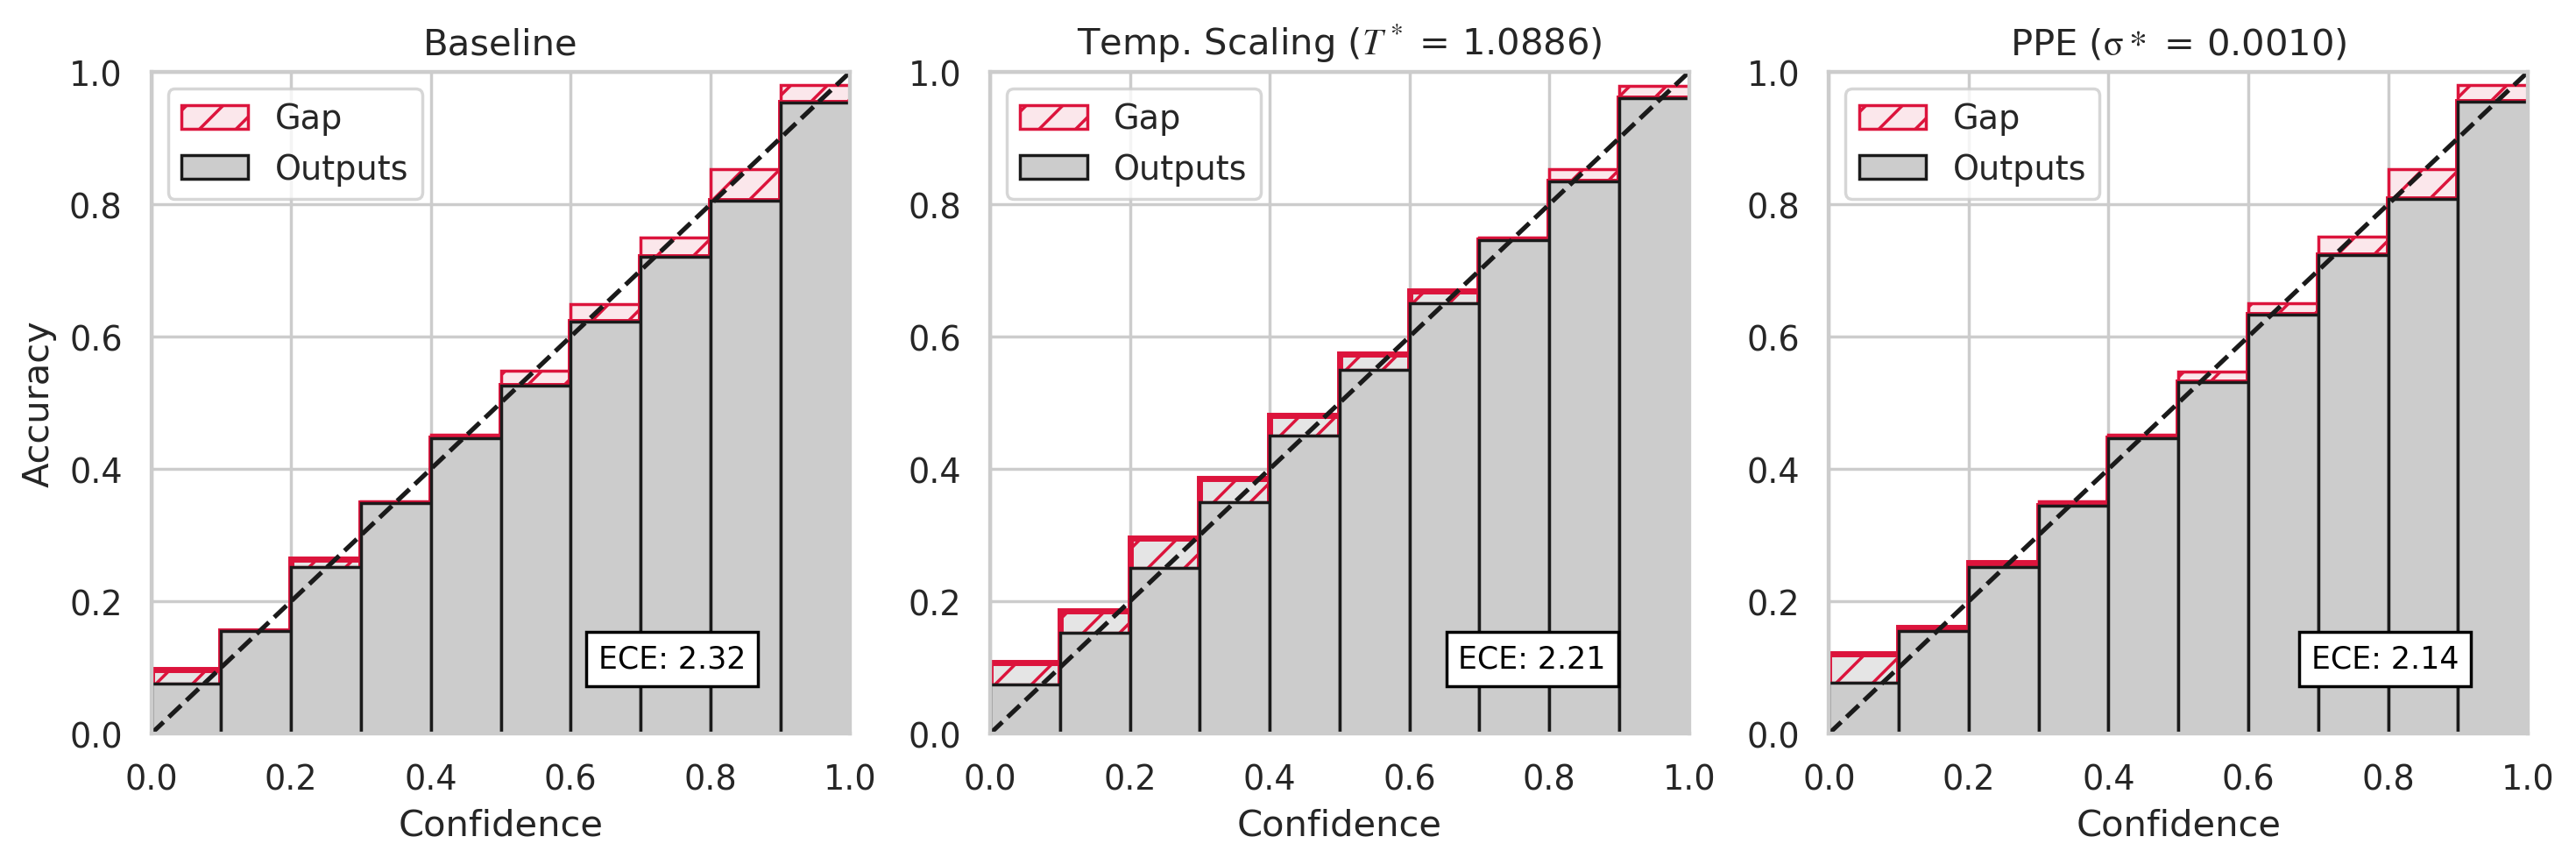

In [45]:
plt.figure(figsize=(14,4), dpi=250)
ax = plt.subplot(131)
plot_confidence(confidence_bl, acc_bl, ax)
ax.set_title('Baseline' )
ax.text(0.64, 0.1, 'ECE: {0:0.2f}'.format(ece_bl), color='black',  bbox=dict(facecolor='white', edgecolor='black'))
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy')
ax = plt.subplot(132)
plot_confidence(confidence_temp, acc_temp, ax)
ax.set_title('Temp. Scaling (' + r'$T^*$' + ' = {0:.4f})'.format(min_t))
ax.text(0.67, 0.1, 'ECE: {0:0.2f}'.format(ece_temp), color='black',  bbox=dict(facecolor='white', edgecolor='black'));
ax.set_xlabel('Confidence')
ax = plt.subplot(133)
plot_confidence(confidence_ppe, acc_ppe, ax)
ax.set_title('PPE (' + r'$\rm{\sigma*}$' + ' = {0:.4f})'.format(sigma_optimum))
ax.text(0.69, 0.1, 'ECE: {0:0.2f}'.format(ece_ppe), color='black',  bbox=dict(facecolor='white', edgecolor='black'));
ax.set_xlabel('Confidence')
plt.savefig(os.path.join(output_folder, 'calibration_maps.png'));